Successfully loaded pre-cpg-combined.csv. Original shape: (338, 9)

Excluding data for LLM: 'gemini-2.5-pro-exp-03-25'
Shape after filtering: (337, 9). 1 rows removed.

Added 'outcome_category' column based on return codes [0, 1] as success.

Value counts for outcome category (after filtering):
outcome_category
Success (Code 0 or 1)    319
Failure (Other Code)      18
Name: count, dtype: int64

--- Return Code Analysis (Filtered Data) ---

Distribution of Return Codes (Raw):
return_code
 0      270
 1       49
-1       11
 127      7
Name: count, dtype: int64


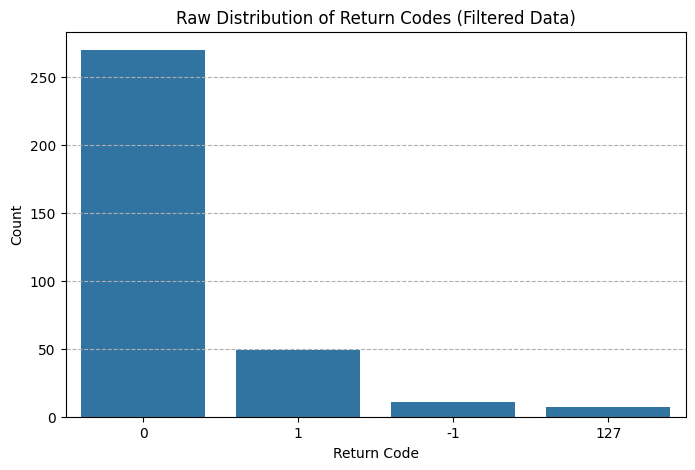


--- LLM Performance Analysis (Filtered Data, Success = Code 0 or 1) ---

Performance per LLM (Filtered Data, Success Definition):
                                Success Rate (%)  Total Attempts
llm_name                                                        
deepseek-chat-v3-0324                  97.872340              47
gemini-2.5-pro-preview-03-25           96.969697              66
llama-3.3-70b-instruct                 95.774648              71
gpt-4.1                                94.827586              58
mistral-small-3.1-24b-instruct         92.753623              69
deepseek-r1-zero                       84.615385              26


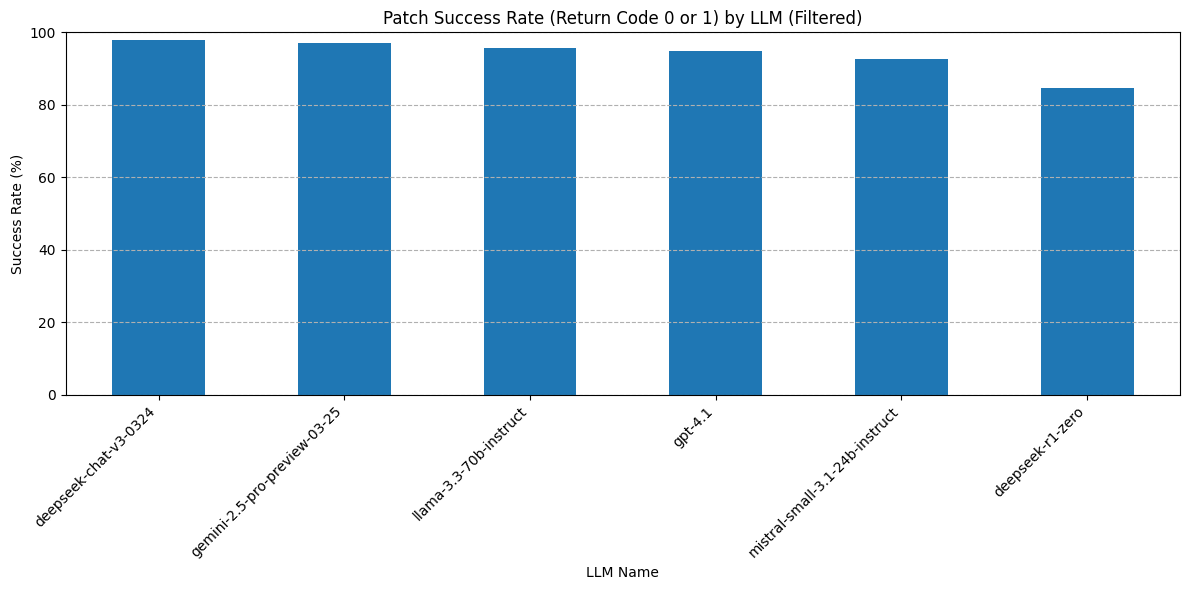

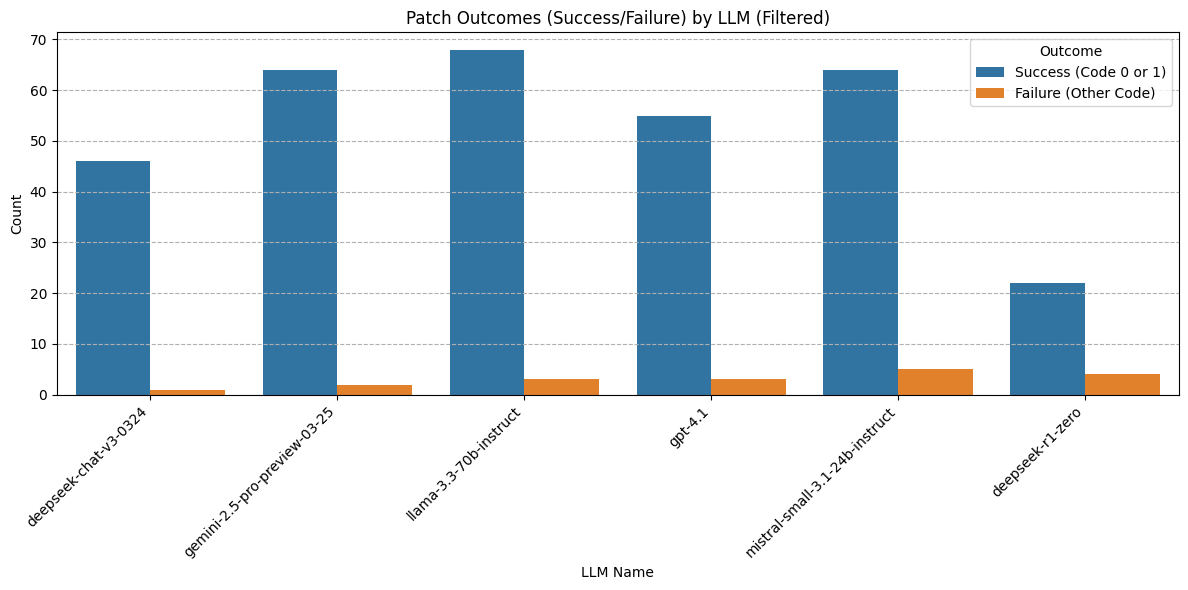


--- Program Performance Analysis (Filtered Data, Success = Code 0 or 1) ---

Performance per Program (Filtered Data):
                         Success Rate (%)  Total Attempts
program_name                                             
boflow1                        100.000000              30
boflow2                        100.000000              31
boflow3_f                      100.000000              22
boflow5                        100.000000              31
complex2                       100.000000              30
complex4                       100.000000              29
fstring4                       100.000000              27
conditional_double_free        100.000000              10
simple_boflow                  100.000000              31
min_heap_double_free           100.000000               5
vulnerable                     100.000000              18
heap_boflow1                    96.969697              33
complex7_f                      70.000000              30
complex6_f 

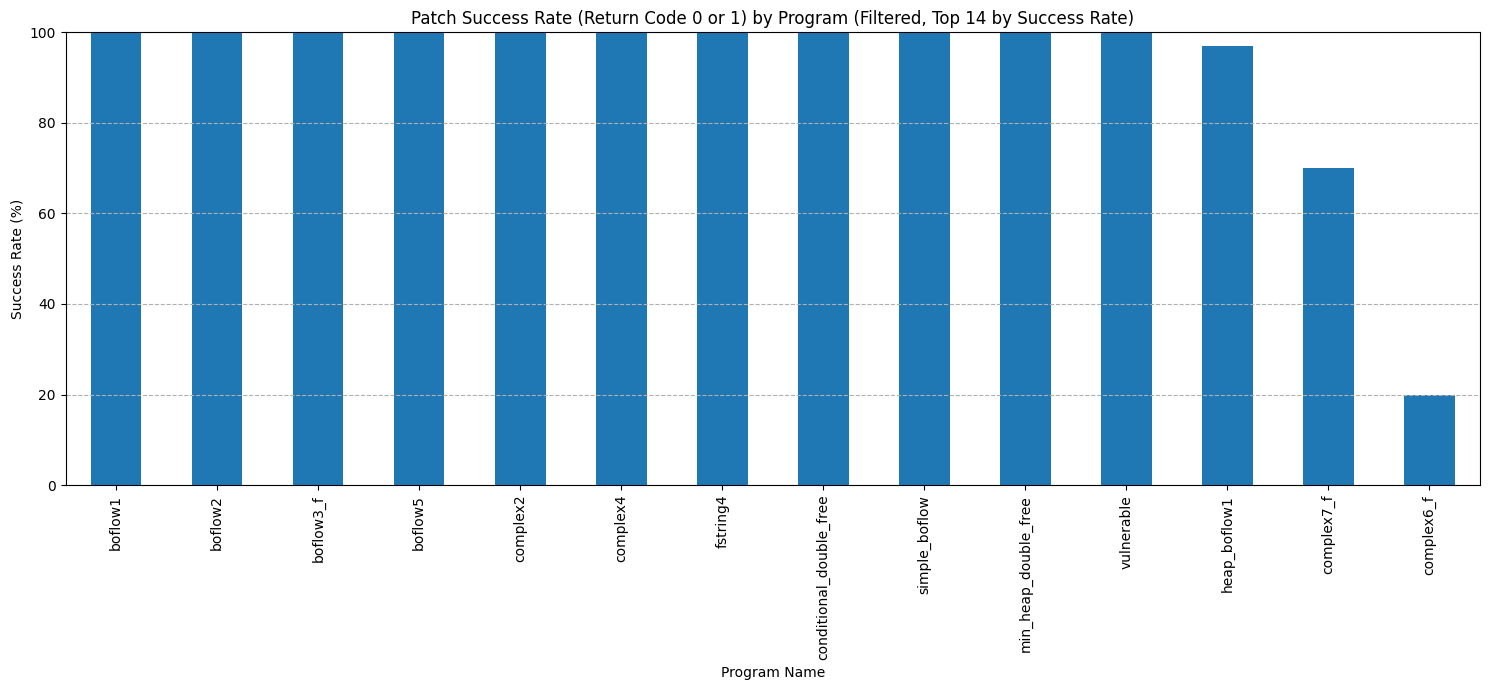

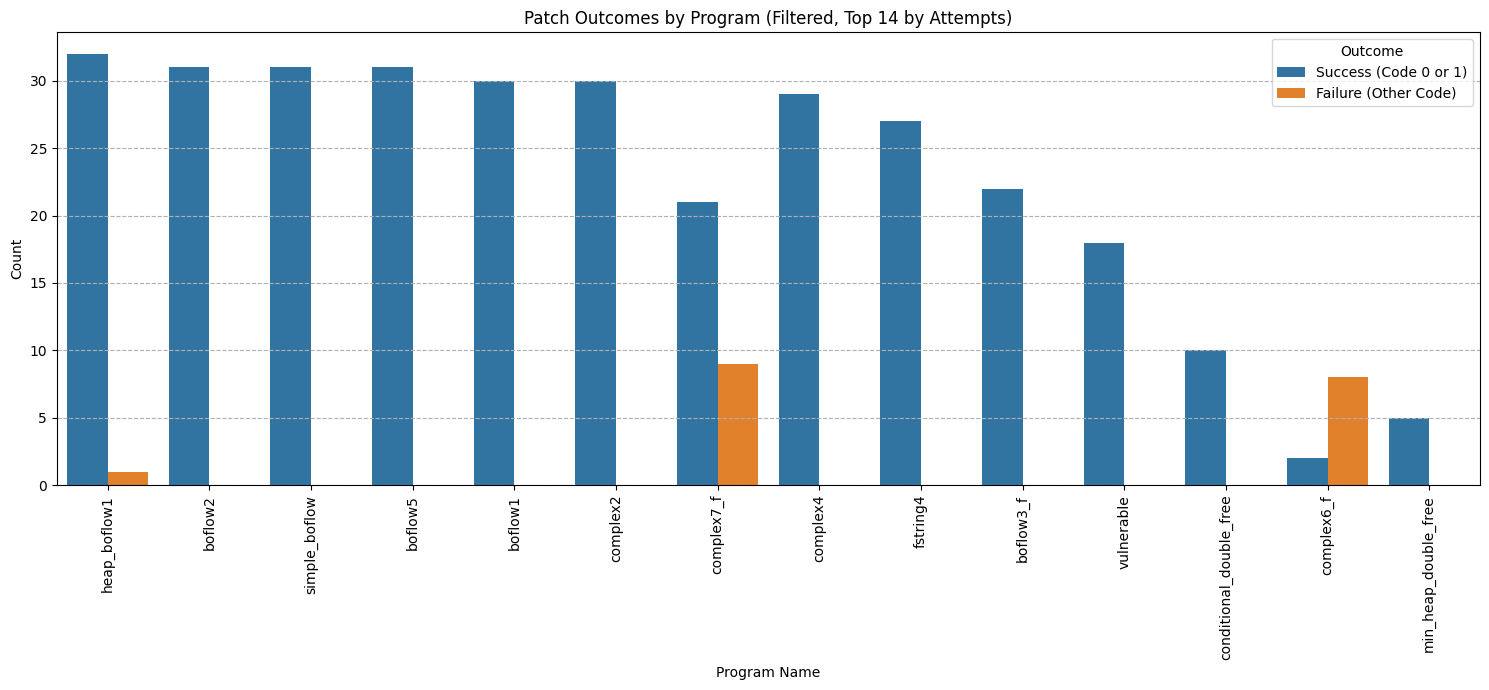


--- Unique Crash Analysis (Filtered Data) ---

Number of unique crash details (using original base64 string): 139

Number of unique crash details per program (Filtered Data, Top 10 by unique crashes):
program_name
boflow2          14
boflow5          14
simple_boflow    14
boflow1          13
complex7_f       13
complex2         13
heap_boflow1     12
complex4         12
fstring4         10
boflow3_f         9
Name: crash_detail, dtype: int64

--- Key Insights (Filtered Data, Success = Code 0 or 1) ---
1.  **Dataset Overview:** The analysis uses 337 records after filtering out LLM 'gemini-2.5-pro-exp-03-25'.
    - The 'patch_base64_str' column is entirely empty.
2.  **Overall Patch Success:** Defining success as return code 0 or 1, 319 out of 337 attempts were successful.
    - This gives an overall success rate of **94.66%**.
    - 18 attempts resulted in other return codes (Failure).
3.  **LLM Performance:** Based on filtered data:
    - 'deepseek-chat-v3-0324' had the highest succe

In [ ]:
# %% [markdown]
# # Analysis of C Program Patching Data
#
# This notebook analyzes the results of using Large Language Models (LLMs) to patch C programs with memory safety bugs.
#
# **Success Definition:** A patch is considered successful if the patched program runs and exits with a return code of `0` or `1`. All other return codes indicate a failure (i.e., the crash was not prevented).
#

# %%
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for isin

# %% [markdown]
# ## 1. Load and Prepare Data

# %%
# Define file path and columns
csv_file = 'combined.csv'
return_code_col = 'return_code'
program_col = 'program_name'
llm_col = 'llm_name'
crash_detail_col = 'crash_detail'
llm_to_exclude = 'gemini-2.5-pro-exp-03-25'

# Load the dataset
try:
    df_original = pd.read_csv(csv_file)
    print(f"Successfully loaded {csv_file}. Original shape: {df_original.shape}")

    # --- Data Filtering ---
    print(f"\nExcluding data for LLM: '{llm_to_exclude}'")
    df = df_original[df_original[llm_col] != llm_to_exclude].copy() # Use .copy() to avoid SettingWithCopyWarning
    print(f"Shape after filtering: {df.shape}. {df_original.shape[0] - df.shape[0]} rows removed.")

    if df.empty:
        print("DataFrame is empty after filtering. Cannot proceed.")
        # Or raise an error: raise ValueError("DataFrame empty after filtering")
    else:
        # --- Data Preparation ---
        # Define 'Success' as return code 0 or 1
        success_codes = [0, 1]
        df['outcome_category'] = np.where(df[return_code_col].isin(success_codes),
                                          'Success (Code 0 or 1)',
                                          'Failure (Other Code)')

        print(f"\nAdded 'outcome_category' column based on return codes {success_codes} as success.")
        print("\nValue counts for outcome category (after filtering):")
        print(df['outcome_category'].value_counts())

except FileNotFoundError:
    print(f"Error: The file '{csv_file}' was not found.")
    df = pd.DataFrame() # Create empty df to avoid errors later if file not found
except Exception as e:
    print(f"An error occurred during data loading or preparation: {e}")
    df = pd.DataFrame() # Create empty df

# %% [markdown]
# ## 2. Return Code Analysis (Raw Distribution)
#
# This shows the distribution of all raw return codes present in the *filtered* dataset.

# %%
if not df.empty and return_code_col in df.columns:
    print("\n--- Return Code Analysis (Filtered Data) ---")
    return_code_counts = df[return_code_col].value_counts()
    print("\nDistribution of Return Codes (Raw):")
    print(return_code_counts)

    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=return_code_col, order=return_code_counts.index)
    plt.title('Raw Distribution of Return Codes (Filtered Data)')
    plt.xlabel('Return Code')
    plt.ylabel('Count')
    plt.grid(axis='y', linestyle='--')
    plt.show()
else:
    print("Skipping Return Code Analysis: DataFrame is empty or missing required columns.")

# %% [markdown]
# ## 3. LLM Performance Analysis
#
# Analyzing LLM performance based on the filtered data and the success definition (return code 0 or 1).

# %%
if not df.empty and llm_col in df.columns and return_code_col in df.columns:
    print("\n--- LLM Performance Analysis (Filtered Data, Success = Code 0 or 1) ---")
    # Calculate success rate (return_code 0 or 1) per LLM
    llm_success_rate_updated = df.groupby(llm_col)[return_code_col].apply(
        lambda x: x.isin(success_codes).mean() * 100
    ).sort_values(ascending=False)
    llm_counts = df[llm_col].value_counts()

    # Check if llm_success_rate_updated index aligns with llm_counts index before creating DataFrame
    llm_stats_updated = pd.DataFrame({
        'Success Rate (%)': llm_success_rate_updated,
        'Total Attempts': llm_counts.reindex(llm_success_rate_updated.index) # Ensure alignment
    }).sort_values(by='Success Rate (%)', ascending=False)

    print("\nPerformance per LLM (Filtered Data, Success Definition):")
    print(llm_stats_updated)

    # Visualize LLM Success Rate
    plt.figure(figsize=(12, 6))
    llm_stats_updated['Success Rate (%)'].plot(kind='bar')
    plt.title('Patch Success Rate (Return Code 0 or 1) by LLM (Filtered)')
    plt.xlabel('LLM Name')
    plt.ylabel('Success Rate (%)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Visualize absolute counts per LLM (Success vs Failure)
    plt.figure(figsize=(12, 6))
    # Use the new 'outcome_category' column for hue
    sns.countplot(data=df, x=llm_col, hue='outcome_category', order=llm_stats_updated.index,
                  hue_order=['Success (Code 0 or 1)', 'Failure (Other Code)'])
    plt.title('Patch Outcomes (Success/Failure) by LLM (Filtered)')
    plt.xlabel('LLM Name')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Outcome')
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

else:
     print("Skipping LLM Performance Analysis: DataFrame is empty or missing required columns.")


# %% [markdown]
# ## 4. Program Performance Analysis
#
# Analyzing Program performance based on the filtered data and success definition (return code 0 or 1).

# %%
if not df.empty and program_col in df.columns and return_code_col in df.columns:
    print("\n--- Program Performance Analysis (Filtered Data, Success = Code 0 or 1) ---")
    # Calculate success rate (return_code 0 or 1) per program
    program_success_rate_updated = df.groupby(program_col)[return_code_col].apply(
        lambda x: x.isin(success_codes).mean() * 100
    )
    program_counts = df[program_col].value_counts()

    # Ensure alignment before creating DataFrame
    program_stats_updated = pd.DataFrame({
        'Success Rate (%)': program_success_rate_updated,
        'Total Attempts': program_counts.reindex(program_success_rate_updated.index)
    }).sort_values(by='Success Rate (%)', ascending=False)

    print("\nPerformance per Program (Filtered Data):")
    print(program_stats_updated)

    # Determine the number of programs to plot
    num_programs_to_plot = min(20, len(program_stats_updated))
    programs_to_plot_success = program_stats_updated.head(num_programs_to_plot)
    programs_to_plot_attempts = program_stats_updated.sort_values(by='Total Attempts', ascending=False).head(num_programs_to_plot)


    # Visualize Program Success Rate (Top N by Success Rate)
    plt.figure(figsize=(15, 7))
    programs_to_plot_success['Success Rate (%)'].plot(kind='bar')
    plt.title(f'Patch Success Rate (Return Code 0 or 1) by Program (Filtered, Top {num_programs_to_plot} by Success Rate)')
    plt.xlabel('Program Name')
    plt.ylabel('Success Rate (%)')
    plt.xticks(rotation=90)
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Visualize absolute counts per program (Top N based on total attempts)
    # Filter data for top programs by attempts *after* confirming df is not empty
    if not programs_to_plot_attempts.empty:
        df_top_programs_attempts = df[df[program_col].isin(programs_to_plot_attempts.index)].copy() # Use .copy()

        plt.figure(figsize=(15, 7))
        # Use the new 'outcome_category' column for hue
        sns.countplot(data=df_top_programs_attempts, x=program_col, hue='outcome_category', order=programs_to_plot_attempts.index,
                    hue_order=['Success (Code 0 or 1)', 'Failure (Other Code)'])
        plt.title(f'Patch Outcomes by Program (Filtered, Top {num_programs_to_plot} by Attempts)')
        plt.xlabel('Program Name')
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.legend(title='Outcome')
        plt.grid(axis='y', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("No programs found to plot based on attempts.")


else:
    print("Skipping Program Performance Analysis: DataFrame is empty or missing required columns.")


# %% [markdown]
# ## 5. Unique Crash Analysis
#
# Identifying unique crashes based on the `crash_detail` column in the filtered data. This is unaffected by the return code definition but uses the filtered dataset.

# %%
if not df.empty and crash_detail_col in df.columns:
    print("\n--- Unique Crash Analysis (Filtered Data) ---")
    num_unique_crashes = df[crash_detail_col].nunique()
    print(f"\nNumber of unique crash details (using original base64 string): {num_unique_crashes}")

    # Optionally, check uniqueness combined with program if relevant
    if program_col in df.columns:
         # Ensure program_col exists before grouping
         num_unique_program_crash = df.groupby(program_col)[crash_detail_col].nunique()
         print("\nNumber of unique crash details per program (Filtered Data, Top 10 by unique crashes):")
         print(num_unique_program_crash.sort_values(ascending=False).head(10))
    else:
        print(f"\nCannot analyze unique crashes per program because '{program_col}' column is missing.")

else:
    print(f"Skipping Unique Crash Analysis: DataFrame is empty or '{crash_detail_col}' column not found.")

# %% [markdown]
# ## 6. Key Insights Summary (Filtered Data)

# %%
if not df.empty:
    print("\n--- Key Insights (Filtered Data, Success = Code 0 or 1) ---")
    print(f"1.  **Dataset Overview:** The analysis uses {df.shape[0]} records after filtering out LLM '{llm_to_exclude}'.")
    # Check if patch column exists before commenting
    if 'patch_base64_str' in df.columns:
         patch_empty = df['patch_base64_str'].isnull().all()
         print(f"    - The 'patch_base64_str' column is {'entirely empty' if patch_empty else 'not empty'}.")
    else:
        print("    - 'patch_base64_str' column not found.")


    if return_code_col in df.columns:
        # Calculate success/failure based on the new definition
        success_count_updated = df['outcome_category'].value_counts().get('Success (Code 0 or 1)', 0)
        failure_count_updated = df['outcome_category'].value_counts().get('Failure (Other Code)', 0)
        total_attempts = success_count_updated + failure_count_updated # Should be df.shape[0]

        if total_attempts > 0:
             overall_success_rate_updated = (success_count_updated / total_attempts) * 100
             print(f"2.  **Overall Patch Success:** Defining success as return code 0 or 1, {success_count_updated} out of {total_attempts} attempts were successful.")
             print(f"    - This gives an overall success rate of **{overall_success_rate_updated:.2f}%**.")
             print(f"    - {failure_count_updated} attempts resulted in other return codes (Failure).")
        else:
             print("2.  **Overall Patch Success:** No attempts found to calculate success rate.")


    if llm_col in df.columns and return_code_col in df.columns and not llm_stats_updated.empty:
        print("3.  **LLM Performance:** Based on filtered data:")
        best_llm = llm_stats_updated.index[0] # Already sorted
        best_rate = llm_stats_updated['Success Rate (%)'].iloc[0]
        worst_llm = llm_stats_updated.index[-1]
        worst_rate = llm_stats_updated['Success Rate (%)'].iloc[-1]
        print(f"    - '{best_llm}' had the highest success rate ({best_rate:.2f}%) over {llm_stats_updated.loc[best_llm, 'Total Attempts']} attempts.")
        print(f"    - '{worst_llm}' had the lowest success rate ({worst_rate:.2f}%) over {llm_stats_updated.loc[worst_llm, 'Total Attempts']} attempts.")
        print("    - See the updated table and charts above for details.")
    elif llm_col not in df.columns:
         print("3.  **LLM Performance:** Could not analyze LLM performance as the 'llm_name' column was not found.")


    if program_col in df.columns and return_code_col in df.columns and not program_stats_updated.empty:
         print(f"4.  **Program Difficulty:** Based on filtered data:")
         easiest_program = program_stats_updated.index[0] # Already sorted
         easiest_rate = program_stats_updated['Success Rate (%)'].iloc[0]
         hardest_program = program_stats_updated.index[-1]
         hardest_rate = program_stats_updated['Success Rate (%)'].iloc[-1]
         # Find most tested based on the correct DataFrame and column
         program_attempts_filtered = df[program_col].value_counts()
         most_tested = program_attempts_filtered.idxmax()
         most_tested_count = program_attempts_filtered.max()


         print(f"    - '{easiest_program}' had the highest success rate ({easiest_rate:.2f}%).")
         print(f"    - '{hardest_program}' had the lowest success rate ({hardest_rate:.2f}%).")
         print(f"    - '{most_tested}' was the most frequently tested program ({most_tested_count} attempts).")
         print(f"    - See the updated table and charts for the top {num_programs_to_plot} programs.")
    elif program_col not in df.columns:
        print("4.  **Program Difficulty:** Could not analyze program difficulty as the 'program_name' column was not found.")


    if crash_detail_col in df.columns:
        # Use num_unique_crashes calculated earlier from filtered data
        print(f"5.  **Unique Crashes:** (Filtered Data) There are {num_unique_crashes} unique crashes identified based on the '{crash_detail_col}' values.")
        if program_col in df.columns and not num_unique_program_crash.empty:
             print("    - The number of unique crashes varies per program (see table above for top programs).")
    elif crash_detail_col not in df.columns:
        print("5.  **Unique Crashes:** Could not determine the number of unique crashes as the 'crash_detail' column was not found.")

else:
    print("Cannot generate summary insights as the DataFrame is empty.")

# %% [markdown]
# --- End of Analysis ---